# Import Libraries

In [1]:
from Network import Network
from Environment import CyberAttack 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.ppo_mask import MaskablePPO

# Synthetic Network

In [2]:
data = {"ID": [0,1,2,3,4,5,6,7,8,9,10,11,12],
        "Type": ["Company","Company","Company","Company","Company","Company","Company",
                 "Company","Company","Company","Third-Party","Third-Party","Fourth-Party"],
        "Size": [100000,11000,12000,13000,14000,15000,16000,17000,18000,19000,50,100000,50000],
        "Incoming_Connections": [[],[],[],[],[],[],[],[],[],[],
                                 [0,1,2,3,4,5,6],[3,4,5,6,7,8,9],[10,11]],
        "Outgoing_Connections": [[10],[10],[10],[10,11],[10,11],[10,11],[10,11],[11],[11],[11],[12],[12],[]],
        "All_Connections": [[10],[10],[10],[10,11],[10,11],[10,11],[10,11],[11],[11],[11],
                            [0,1,2,3,4,5,6,12],[3,4,5,6,7,8,9,12],[10,11]]}

network = pd.DataFrame(data)
network

,ID,Type,Size,Incoming_Connections,Outgoing_Connections,All_Connections
0,0,Company,100000,[],[10],[10]
1,1,Company,11000,[],[10],[10]
2,2,Company,12000,[],[10],[10]
3,3,Company,13000,[],"[10, 11]","[10, 11]"
4,4,Company,14000,[],"[10, 11]","[10, 11]"
5,5,Company,15000,[],"[10, 11]","[10, 11]"
6,6,Company,16000,[],"[10, 11]","[10, 11]"
7,7,Company,17000,[],[11],[11]
8,8,Company,18000,[],[11],[11]
9,9,Company,19000,[],[11],[11]


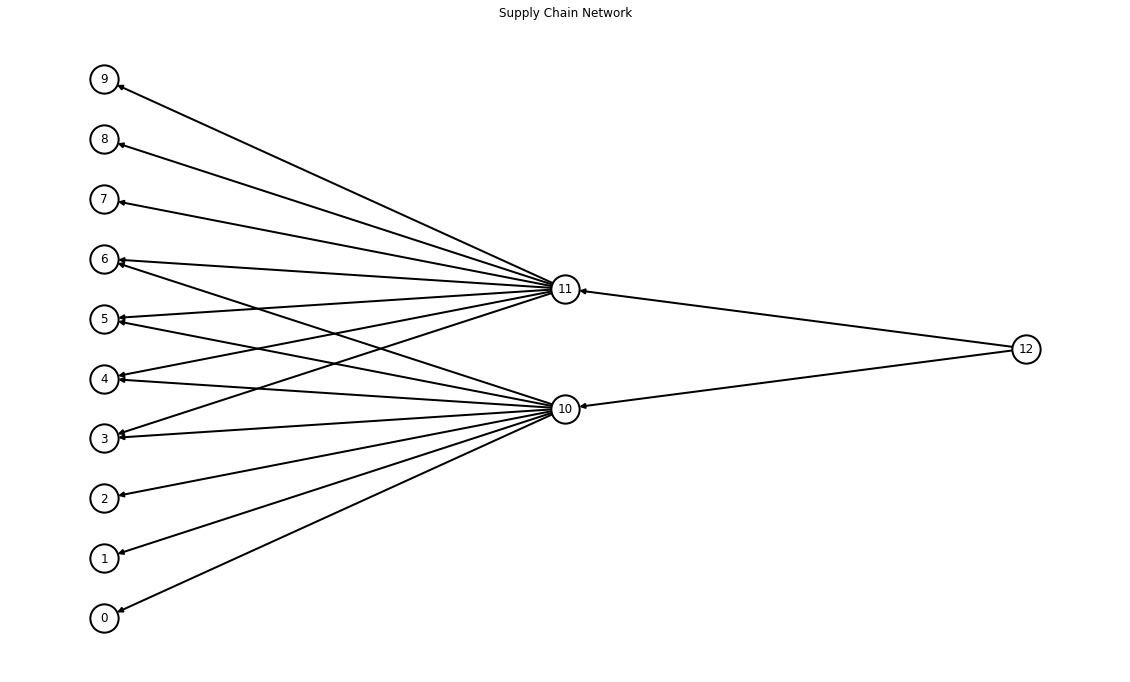

In [3]:
G = nx.DiGraph()

left_nodes = []
middle_nodes = []
right_nodes = []

for row in network.itertuples():
    if row.Type == "Company":
        left_nodes.append(row.ID)
    elif row.Type == "Third-Party":
        middle_nodes.append(row.ID)
    else:
        right_nodes.append(row.ID)
    for connection in row.Outgoing_Connections:
        G.add_edge(connection,row.ID)
        
pos = {n: (0,i) for i, n in enumerate(left_nodes)}
pos.update({n: (1,np.mean(left_nodes)-1+2*i) for i, n in enumerate(middle_nodes)})
pos.update({n: (2,np.mean(left_nodes)) for i, n in enumerate(right_nodes)})

options = {
    "font_size": 12,
    "node_size": 800,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}

figure = plt.figure(figsize=(20,12))
nx.draw_networkx(G,pos,**options)
plt.axis("off")
plt.title("Supply Chain Network")
plt.show()

# Attacks/Rewards

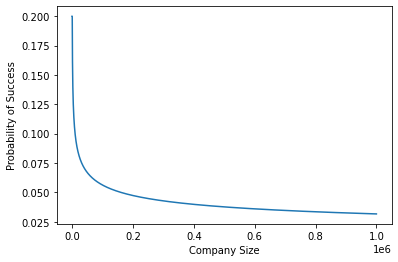

In [4]:
def probability(size):
    return min(.2,size**(-.25))

x = np.arange(1,1e6,1)
p = [probability(i) for i in x]
plt.plot(x,p)
plt.xlabel("Company Size")
plt.ylabel("Probability of Success")
plt.show()

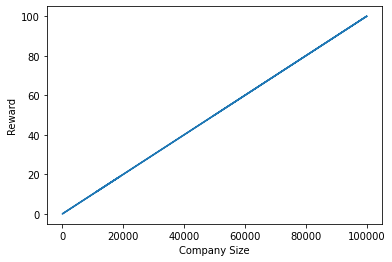

In [5]:
def reward(size):
    return (size/1000)

x = network["Size"].values
p = [reward(i) for i in x]
plt.plot(x,p)
plt.xlabel("Company Size")
plt.ylabel("Reward")
plt.show()

# Theoretical Performance

##### Unconstrained

In [6]:
unconstrained_theoretical_steps = 0
unconstrained_theoretical_reward = 0

for row in network.itertuples():
    if row.ID == 12:
        continue
    p = min(.2,row.Size**(-.25))
    r = row.Size/1000
    expected_number_steps = 1/p
    expected_reward = r - expected_number_steps
    unconstrained_theoretical_steps += expected_number_steps
    unconstrained_theoretical_reward += expected_reward

print(f"Expected Total Steps: {unconstrained_theoretical_steps:.2f}")
print(f"Expected Total Reward: {unconstrained_theoretical_reward:.2f}")

Expected Total Steps: 139.88
Expected Total Reward: 195.17


##### Constrained

In [7]:
constrained_theoretical_reward = 173.16094108689867
constrained_theoretical_policy = [0, 8, 9, 10, 11, 12]

# RL Performance

##### Unconstrained Performance

In [8]:
def mask_fn(env):
    a_out = np.array(env.state["accessible_out"],dtype=bool)
    a_in = np.array(env.state["accessible_in"],dtype=bool)
    c = np.array(env.state["compromised"],dtype=bool)
    mask = ~(~(a_out|a_in)|c)
    mask = np.array(mask,dtype=np.int32)
    return mask

In [15]:
env = CyberAttack(network,compromised_nodes=[12],shotgun_attack=False)
env.reset()
env = ActionMasker(env,mask_fn)
env.state

{'current_node': 12,
 'compromised': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32),
 'accessible_out': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'accessible_in': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int32),
 'size': array([100000,  11000,  12000,  13000,  14000,  15000,  16000,  17000,
         18000,  19000,     50, 100000,  50000], dtype=int32)}

In [11]:
model = MaskablePPO("MultiInputPolicy",env,verbose=0)
model.learn(total_timesteps=50000)

In [12]:
def get_performance(steps):
    env = CyberAttack(network,compromised_nodes=[12],shotgun_attack=False)
    env.reset()
    env = ActionMasker(env,mask_fn)
    obs = env.state

    number_steps = 0
    total_reward = 0
    terminated = False

    for i in range(steps):
        action_masks = mask_fn(env)
        action,_states = model.predict(obs,action_masks=action_masks,deterministic=True)
        obs,reward,done,info = env.step(action)
        number_steps += 1
        total_reward += reward
        if done:
            terminated = True
            break

    return((number_steps,total_reward,terminated))  

In [13]:
unconstrained_rl_steps = []
unconstrained_rl_reward = []

for _ in range(100):
    result = get_performance(1000)
    unconstrained_rl_steps.append(result[0])
    unconstrained_rl_reward.append(result[1])
    
unconstrained_rl_steps = np.mean(unconstrained_rl_steps)
unconstrained_rl_reward = np.mean(unconstrained_rl_reward)
    
print(f"Average Total Steps: {unconstrained_rl_steps:.2f}")
print(f"Average Total Reward: {unconstrained_rl_reward:.2f}")

Average Total Steps: 142.81
Average Total Reward: 204.24


##### Constrained Performance

In [14]:
env = CyberAttack(network,compromised_nodes=[12],step_limit=70,shotgun_attack=False)
env.reset()
env = ActionMasker(env,mask_fn)
env.state

{'current_node': 12,
 'compromised': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int32),
 'accessible_out': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 'accessible_in': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0], dtype=int32),
 'size': array([100000,  11000,  12000,  13000,  14000,  15000,  16000,  17000,
         18000,  19000,     50, 100000,  50000], dtype=int32)}

In [21]:
model = MaskablePPO("MultiInputPolicy",env,verbose=0)
model.learn(total_timesteps=50000)

In [22]:
constrained_rl_policy = [12]
env = CyberAttack(network,compromised_nodes=[12],step_limit=70,shotgun_attack=False)
env.reset()
env = ActionMasker(env,mask_fn)
obs = env.state
for i in range(1000):
    action_masks = mask_fn(env)
    action,_states = model.predict(obs,action_masks=action_masks,deterministic=True)
    obs,reward,done,info = env.step(action)
    if action not in constrained_rl_policy:
        constrained_rl_policy.append(int(action))
        
constrained_rl_reward = []
for _ in range(100):
    result = get_performance(70)
    constrained_rl_reward.append(result[1])
constrained_rl_reward = np.mean(constrained_rl_reward)
    
print(f"Policy: {constrained_rl_policy}")
print(f"Average Total Reward: {constrained_rl_reward:.2f}")

Policy: [12, 11, 7, 10, 0, 2, 9, 8, 1, 6, 3, 5, 4]
Average Total Reward: 170.88


# Results

In [23]:
print("Unconstrained Performance:")
print(f"Theoretical Steps: {unconstrained_theoretical_steps:.2f}")
print(f"RL Steps: {unconstrained_rl_steps:.2f}")
print(f"Theoretical Reward: {unconstrained_theoretical_reward:.2f}")
print(f"RL Reward: {unconstrained_rl_reward:.2f}")

print()

print("Constrained Performance (step limit = 70)")
print(f"Theoretical Reward: {constrained_theoretical_reward:.2f}")
print(f"RL Reward: {constrained_rl_reward:.2f}")
print(f"Theoretical Policy: {set(constrained_theoretical_policy)}")
print(f"RL Policy: {constrained_rl_policy[:6]} -> {constrained_rl_policy[6:]}")

Unconstrained Performance:
Theoretical Steps: 139.88
RL Steps: 142.81
Theoretical Reward: 195.17
RL Reward: 204.24

Constrained Performance (step limit = 70)
Theoretical Reward: 173.16
RL Reward: 170.88
Theoretical Policy: {0, 8, 9, 10, 11, 12}
RL Policy: [12, 11, 7, 10, 0, 2] -> [9, 8, 1, 6, 3, 5, 4]
